<a href="https://colab.research.google.com/github/hllj/fer-dexpression/blob/master/FER_deXpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q -U opencv-python

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install keras==2.0.0
!pip install tensorflow==2.0

In [0]:
root_path = 'gdrive/My Drive/FER-Model' #my folder directory 

In [0]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
from __future__ import print_function
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Reshape, Permute, Concatenate, Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ELU
from tensorflow.keras.utils import get_source_inputs, get_file, convert_all_kernels_in_model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [0]:
print(tf.__version__)

1.15.0


In [0]:
df_train = pd.read_csv(root_path + '/train.csv')
df_test = pd.read_csv(root_path + '/test.csv')
df_test.head()

,Folder,ImageName,Emotion,Label
0,gdrive/My Drive/FER-Model/CK+/neutral/,S072_002_00000001.png,neutral,5
1,gdrive/My Drive/FER-Model/CK+/neutral/,S113_006_00000001.png,neutral,5
2,gdrive/My Drive/FER-Model/CK+/neutral/,S050_005_00000001.png,neutral,5
3,gdrive/My Drive/FER-Model/CK+/neutral/,S506_001_00000001.png,neutral,5
4,gdrive/My Drive/FER-Model/CK+/neutral/,S114_005_00000001.png,neutral,5


### 1.Load Train Set and Test Set

In [0]:
def load_image_df(df):
  images = []
  labels = []
  for i in range(df.shape[0]):
    path1 = df.iloc[i]['Folder']
    path2 = df.iloc[i]['ImageName']
    read_image = cv2.imread(path1 + path2)
    read_image = cv2.resize(read_image, (224, 224))
    read_image_final = read_image / 255.0
    images.append(read_image_final)
    labels.append(df.iloc[i]['Label'])
  return np.array(images), np.array(labels)

In [0]:
X_train, y_train = load_image_df(df_train)
X_train.shape

(827, 224, 224, 3)

In [0]:
X_test, y_test = load_image_df(df_test)
X_test.shape

(92, 224, 224, 3)

### 1.1 Pre-processing data

In [0]:
print("X_train 's shape : ", X_train.shape)
print("y_train 's shape : ", y_train.shape)


X_train 's shape :  (827, 224, 224, 3)
y_train 's shape :  (827,)


In [0]:
X_train = X_train.reshape(-1, 224, 224, 3)

In [0]:
print("X_test 's shape : ", X_test.shape)
print("y_test 's shape : ", y_test.shape)


X_test 's shape :  (92, 224, 224, 3)
y_test 's shape :  (92,)


In [0]:
X_test = X_test.reshape(-1, 224, 224, 3)

In [0]:
train_labels = keras.utils.to_categorical(y_train, num_classes=8)
test_labels = keras.utils.to_categorical(y_test, num_classes=8)

In [0]:
print(y_train[1], " ", train_labels[1])

5   [0. 0. 0. 0. 0. 1. 0. 0.]


### 2.Create model

In [0]:
input_shape = (224, 224, 3)
no_of_classes = 8

In [0]:
imagesize=224
dropout_rate=0.8
LR=0.001
batch_size=128
num_epoch=100

padding='VALID'

In [0]:
def DeXpression(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                padding=None,
                classes=8):
    # Check weights
    if weights not in {'dexpression', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `dexpression` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 7:
        raise ValueError('If using `weights` as dexpression with `include_top`'
                         ' as true, `classes` should be 7')
    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=139,
        data_format=K.image_data_format(),
        include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    # START MODEL
    conv_1 = Convolution2D(64, (7, 7), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(img_input)
    maxpool_1 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    x = BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = Convolution2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    conv_2c = Convolution2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = Concatenate(axis=3, name='concat_1')([conv_2b,conv_2c])
    maxpool_2b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2b')(concat_1)
    
    # FEAT-EX2
    conv_3a = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_3a')(maxpool_2b)
    conv_3b = Convolution2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_3b')(conv_3a)
    maxpool_3a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3a')(maxpool_2b)
    conv_3c = Convolution2D(64, (1, 1), strides=(1,1), name='conv_3c')(maxpool_2a)
    concat_3 = Concatenate(axis=3, name='concat_3')([conv_3b,conv_3c])
    maxpool_3b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3b')(concat_3)
    
    # FINAL LAYERS
    net = Flatten()(maxpool_3b)
    net = Dense(classes, activation='softmax', name='predictions')(net)
    
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, net, name='deXpression')
    return model



In [0]:
model = DeXpression(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                padding='same',
                classes=8)
model.summary()

Model: "deXpression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 64)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 55, 55, 64)   256         max_pooling2d[0][0]              
________________________________________________________________________________________

In [0]:
adam = tf.keras.optimizers.Adam(lr=LR, decay=LR/num_epoch)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5", 
                                     monitor='val_acc',
                                     mode='max', 
                                     verbose=0, 
                                     save_best_only=True)

In [0]:
#Data Augmentation
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )

In [0]:
generator = gen.flow(X_train, train_labels, batch_size = batch_size)

In [0]:
history = model.fit_generator(generator, steps_per_epoch=len(X_train)/batch_size,
                              validation_data=(X_test, test_labels), epochs=num_epoch, callbacks=[mc])

Epoch 1/100
7/6 [================================] - 11s 2s/step - loss: 31.2629 - acc: 0.3942 - val_loss: 2.5236 - val_acc: 0.6196
Epoch 2/100
7/6 [================================] - 8s 1s/step - loss: 7.1735 - acc: 0.5067 - val_loss: 3.5098 - val_acc: 0.3152
Epoch 3/100
7/6 [================================] - 8s 1s/step - loss: 4.7299 - acc: 0.4353 - val_loss: 3.1833 - val_acc: 0.5326
Epoch 4/100
7/6 [================================] - 8s 1s/step - loss: 3.4327 - acc: 0.5006 - val_loss: 4.0439 - val_acc: 0.1630
Epoch 5/100
7/6 [================================] - 8s 1s/step - loss: 2.7931 - acc: 0.4619 - val_loss: 3.2254 - val_acc: 0.5870
Epoch 6/100
7/6 [================================] - 9s 1s/step - loss: 2.3636 - acc: 0.4946 - val_loss: 3.7374 - val_acc: 0.6196
Epoch 7/100
7/6 [================================] - 8s 1s/step - loss: 2.3167 - acc: 0.5308 - val_loss: 3.8240 - val_acc: 0.6304
Epoch 8/100
7/6 [================================] - 8s 1s/step - loss: 2.1629 - acc: 0.

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

In [0]:
epochs = range(1, num_epoch + 1)

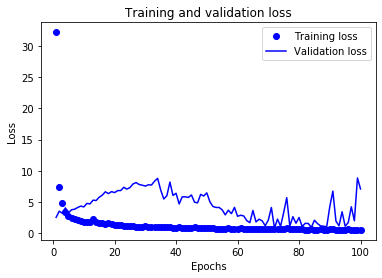

In [0]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

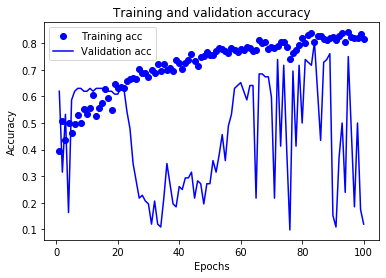

In [0]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
model.load_weights('model-dexpression.h5')

In [0]:
model.evaluate(X_test, test_labels)

92/92 [==============================] - 0s 3ms/sample - loss: 0.8243 - acc: 0.8043


[0.8243244186691616, 0.8043478]

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
EMOTION_DICT = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
def make_prediction(model, path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path, gray)

    face_cascade = cv2.CascadeClassifier(root_path + '/haarcascade_frontalface_default.xml') 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_clip = img[y:y + h, x:x + w]
        cv2.imwrite(path, cv2.resize(face_clip, (224, 224)))
    
    # # read the processed image then make prediction and display the result
    read_image = cv2.imread(path)
    cv2_imshow(read_image)
    read_image = cv2.resize(read_image, (224, 224))
    read_image = read_image.reshape(1, 224, 224, 3)
    read_image_final = read_image / 255.0  # normalizing the image

    top_pred = model.predict(read_image_final)
    emotion_label = top_pred[0].argmax()
    print("Predicted Expression Probabilities")
    for idx, emotion in enumerate(EMOTION_DICT):
      print(emotion, " : ", top_pred[0][idx])
    print("Dominant Probability = " + str(EMOTION_DICT[emotion_label]) + ": " + str(max(top_pred[0])))


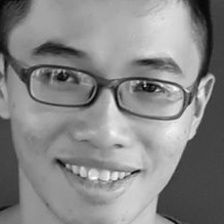

Predicted Expression Probabilities
anger  :  2.2302213e-06
contempt  :  3.913717e-13
disgust  :  0.13709651
fear  :  2.8037354e-07
happiness  :  0.85430825
neutral  :  0.008581611
sadness  :  1.246174e-10
surprise  :  1.1092273e-05
Dominant Probability = happiness: 0.85430825


In [0]:
make_prediction(model, 'test.jpg')

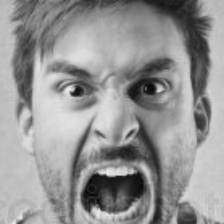

Predicted Expression Probabilities
anger  :  0.0051851524
contempt  :  6.332666e-05
disgust  :  0.41096735
fear  :  0.017042194
happiness  :  0.0020300266
neutral  :  0.33297896
sadness  :  0.00011872084
surprise  :  0.23161429
Dominant Probability = disgust: 0.41096735


In [0]:
make_prediction(model, 'test_angry.jpg')

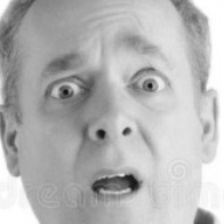

Predicted Expression Probabilities
anger  :  0.0030676066
contempt  :  7.275216e-05
disgust  :  0.00051010086
fear  :  0.0032231112
happiness  :  0.00044402643
neutral  :  0.98492277
sadness  :  0.00046057583
surprise  :  0.0072990013
Dominant Probability = neutral: 0.98492277


In [0]:
make_prediction(model, 'test_surprise.jpg')

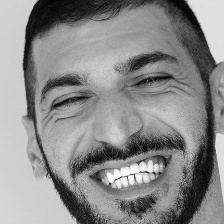

Predicted Expression Probabilities
anger  :  0.008456849
contempt  :  1.6853427e-06
disgust  :  0.028700937
fear  :  0.04793952
happiness  :  0.7431747
neutral  :  0.1332389
sadness  :  0.023463806
surprise  :  0.015023697
Dominant Probability = happiness: 0.7431747


In [0]:
make_prediction(model, 'test_happy.jpg')